In [1]:
from collections import Counter
import pandas as pd
import numpy as np
import tqdm
import pickle
import matplotlib.pyplot as plt
from Bio.PDB import *
from rdkit import Chem
import os
import time
import shutil
from Bio.SeqUtils import seq1
import gzip
import tarfile
import sys
import random
from rdkit.Chem import rdFreeSASA
from rdkit import Chem
from rdkit.Chem.Descriptors import MolWt
import urllib
from lxml import etree
import requests as r
from Bio import SeqIO
from io import StringIO

In [2]:
def good_ligand(inchi):
    try:
        m = Chem.MolFromInchi(inchi)
        count_carbons = 0
        for i in m.GetAtoms():
            if int(i.GetAtomicNum()) == 6:
                count_carbons += 1
            if count_carbons >= 7:
                break
        return count_carbons >= 7
    except:
        return False
    

# Natural amino acids
nat_aa = {'ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'}
maestro_blacklist = set([i.strip() for i in pd.read_csv("/aloy/home/acomajuncosa/PocketVec_v2/kinase/PDB/LIG/preprocess/maestro_blacklist.csv")[' Residue']])
# uninteresting_ligands = pickle.load(open("/aloy/home/acomajuncosa/Apps_PocketVec/HT/PDB/uninteresting_ligands.pkl", "rb")) ## Not using it, for the moment
original_wd = os.getcwd()

In [3]:
### GET INTERESTING LIGANDS

###../data/PDB and LIGAND_PDB mapping --> https://www.ebi.ac.uk/thornton-srv/databases/pdbsum/data/lig_pairs.lst
###  2. PDB and HET_PDB mapping --> https://www.ebi.ac.uk/thornton-srv/databases/pdbsum/data/het_pairs.lst
###  3. Mapping 3-letter PDB code with inchi --> http://ligand-expo.rcsb.org/ld-download.html

pdbcode_to_inchi = pd.read_csv("../data/PDB/mapping/Components-inchi.ich.txt", sep="\t", header=None, names=['inchi', 'PDB', 'name'], usecols=[0,1])  
# From df to dict's  // PDB-LIGs
d = {}
for i,j in zip(pdbcode_to_inchi['inchi'], pdbcode_to_inchi['PDB']):
    if str(j) == 'nan': j = "NA"
    d[str(j)] = i
pdbcode_to_inchi = d; del d

# interesting_ligands = set()

# for lig in tqdm.tqdm(sorted(pdbcode_to_inchi)):
#     inchi = pdbcode_to_inchi[lig]
#     if "-" not in lig and lig not in maestro_blacklist and lig not in nat_aa and good_ligand(inchi) is True:
#         interesting_ligands.add(lig)
        
# pickle.dump(interesting_ligands, open("../pocketvec/PDB/interesting_ligands.pkl", "wb"))
interesting_ligands = pickle.load(open("../pocketvec/PDB/interesting_ligands.pkl", "rb"))

In [4]:
### FIND INTERESTING PDBS

pdbs_intlig = {}  # Interesting ligands
pdbs_lig = {}  # Non interesting ligands
pdbs_het = {}  # Other (e.g. non std residues)

with open("../data/PDB/mapping/lig_pairs.lst.txt", "r") as f:
    for l in f:
        pdb = l.split(":")[0].strip()
        ligs = [i.strip().strip("_") for i in l.split(":")[1].split(";")[:-1]]
        intligs = [i for i in ligs if i in interesting_ligands]
        ligs = [j for i in ligs for j in i.split("-") if j not in intligs]
        if len(ligs) > 0:
            pdbs_lig[pdb] = ligs
        if len(intligs) > 0:
            pdbs_intlig[pdb] = intligs
            
with open("../data/PDB/mapping/het_pairs.lst.txt", "r") as f:
    for l in f:
        pdb = l.split(":")[0].strip()
        hets = [i.strip() for i in l.split(":")[1].split(";")[:-1]]
        if len(hets) > 0:
            pdbs_het[pdb] = hets
            
ligands = [j for i in sorted(pdbs_intlig) for j in pdbs_intlig[i]]

In [5]:
### PREPARE THE DATAFRAME

In [6]:
# File obtained from https://ftp.ebi.ac.uk/pub/databases/pdb/derived_data/pdb_entry_type.txt
pdb_to_entrytype = pd.read_csv("../data/PDB/mapping/pdb_entry_type.txt", sep="\t", header=None, names=['PDB', 'type', 'method'])
pdb_to_entrytype = {i: j for i,j in zip(pdb_to_entrytype['PDB'], pdb_to_entrytype['type'])}

In [7]:
pdb_chain_to_uniprot = {}
pdb_to_chain = {}
df = pd.read_csv("/aloy/home/acomajuncosa/Other_Datasets/Mappings/pdb_chain_uniprot.tsv", skiprows=1, sep='\t')
#df = pd.read_csv("/aloy/home/acomajuncosa/Other_Datasets/Mappings/pdb_uniprot_chain_map.lst.2", skiprows=0, sep=' ', names=['PDB', 'CHAIN', 'SP_PRIMARY'])
for i, j, k in zip(df['PDB'], df['CHAIN'], df['SP_PRIMARY']):
    if str(i) not in pdb_to_chain:
        pdb_to_chain[str(i)] = set()
    pdb_to_chain[str(i)].add(str(j))
    if str(i) + "_" + str(j) not in pdb_chain_to_uniprot:
        pdb_chain_to_uniprot[str(i) + "_" + str(j)] = []
    pdb_chain_to_uniprot[str(i) + "_" + str(j)].append(k)
    
for i in sorted(pdb_chain_to_uniprot):
    pdb_chain_to_uniprot[i] = sorted([j for j in set(pdb_chain_to_uniprot[i]) if str(j) != "nan"])

print(len(pdb_chain_to_uniprot))
for i in sorted(pdb_chain_to_uniprot):
    if len(pdb_chain_to_uniprot[i]) != 1:  # Delete those having >1 uniprot in the pdb chain
        del pdb_chain_to_uniprot[i]
print(len(pdb_chain_to_uniprot))

611876
605628


In [172]:
data = []

for pdb in sorted(pdbs_intlig):
    # Interesting ligands
    for intlig in pdbs_intlig[pdb]:
        # Non interesting ligands
        lig = []
        if pdb in pdbs_lig:
            lig.extend(pdbs_lig[pdb])
        if pdb in pdbs_intlig:
            lig.extend([i for i in pdbs_intlig[pdb] if i != intlig])
        if len(lig) == 0:
            lig = np.nan
        else:
            lig = ",".join(set(lig))
        # Hetatms
        try:
            het = pdbs_het[pdb]
            het = [i for i in het if i not in pdbs_intlig[pdb]]
            if pdb in pdbs_lig:
                het = [i for i in het if i not in pdbs_lig[pdb]]
            if len(het) == 0:
                het = np.nan
            else:
                het = ",".join(het)
        except:
            het = np.nan
            
        if pdb in pdb_to_entrytype and pdb_to_entrytype[pdb] == 'prot' and pdb in pdb_to_chain:
            for chain in pdb_to_chain[pdb]:
                if pdb + "_" + chain in pdb_chain_to_uniprot:
                    uniprot = pdb_chain_to_uniprot[pdb + "_" + chain]
                    data.append([pdb.upper(), intlig, lig, het, pdb_to_entrytype[pdb], chain, uniprot[0]])
        # if pdb in pdb_to_entrytype:
        #     data.append([pdb.upper(), intlig, lig, het, pdb_to_entrytype[pdb]])
        # else:
        #     data.append([pdb.upper(), intlig, lig, het, 'Undefined'])
                
data = pd.DataFrame(data, columns=['PDB', 'INT_LIG', 'LIG', 'HET', 'type', 'chain', 'uniprot'])
# data = data.loc[data['type'] == 'prot'].reset_index()
# del data['index']
data

,PDB,INT_LIG,LIG,HET,type,chain,uniprot
0,10GS,VWW,MES,NaN,prot,A,P09211
1,10GS,VWW,MES,NaN,prot,B,P09211
2,11BA,UPA,SO4,NaN,prot,A,P00669
3,11BA,UPA,SO4,NaN,prot,B,P00669
4,11BG,U2G,SO4,NaN,prot,A,P00669
...,...,...,...,...,...,...,...
285082,9NSE,H4B,"ACT,GOL,ISU,ZN,HEM,CAD",NaN,prot,A,P29473
285083,9NSE,H4B,"ACT,GOL,ISU,ZN,HEM,CAD",NaN,prot,B,P29473
285084,9RSA,ADU,NaN,NaN,prot,A,P61823
285085,9RSA,ADU,NaN,NaN,prot,B,P61823


In [173]:
elements = []
for pdb, int_lig, lig, het, chain_id, uniprot in zip(data['PDB'], data['INT_LIG'], data['LIG'], data['HET'], data['chain'], data['uniprot']):
    if type(lig) == str and type(het) == str:
        elements.append([pdb, int_lig, lig.split(","), het.split(","), chain_id, uniprot])
    if type(lig) != str and type(het) != str:
        elements.append([pdb, int_lig, np.nan, np.nan, chain_id, uniprot])
    if type(lig) == str and type(het) != str:
        elements.append([pdb, int_lig, lig.split(","), np.nan, chain_id, uniprot])
    if type(lig) != str and type(het) == str:
        elements.append([pdb, int_lig, np.nan, het.split(","), chain_id, uniprot])

elements = np.array_split(np.array(elements, dtype='object'), 5000)

In [174]:
import sys
sys.path.insert(0, '/aloy/home/acomajuncosa/programs/hpc') #CHANGE THIS PATH TO YOUR HPC PATH!
from hpc import HPC
from sbnb_config import config as cluster_config

scratch_path = "/aloy/scratch/acomajuncosa/MurD/PDB/prep1" 
script_path = "/aloy/home/acomajuncosa/MurD/GitHub/osa-murd/pocketvec/PDB/scripts/prepare_sts_PDB_LIG.py"

cluster_config['queue'] = 'all.q'

ncpus = 2
cluster = HPC(**cluster_config)
njobs = len(elements)

cluster_params = {}
cluster_params['job_name'] = 'pdb_parse'
cluster_params["jobdir"] = scratch_path
cluster_params["memory"] = ncpus
cluster_params['cpu'] = ncpus
cluster_params["wait"] = False
cluster_params["elements"] = elements
cluster_params["num_jobs"] = len(elements)


singularity_image = "/aloy/home/acomajuncosa/images/image_2021_09_stprep.simg"
command = "singularity exec {} python {} <TASK_ID> <FILE>".format(
singularity_image,
script_path)

cluster.submitMultiJob(command, **cluster_params)

2022-06-12 15:04:37,260 chemicalchecker.util.config.config.Config [DEBUG   ] CC_CONFIG environment variable not set. Using default config file.
2022-06-12 15:04:37,260 chemicalchecker.util.config.config.Config [DEBUG   ] Loading config from: /home/acomajuncosa/programs/anaconda3/lib/python3.7/site-packages/chemicalchecker/util/config/cc_config.json
2022-06-12 15:04:37,994 hpc.HPC      [DEBUG   ] HPC system to use: sge
2022-06-12 15:04:37,994 hpc.HPC      [DEBUG   ] initializing object sge


module 'matplotlib.font_manager' has no attribute '_rebuild'


/home/acomajuncosa/programs/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [197]:
path = "/aloy/scratch/acomajuncosa/MurD/PDB/prep1"
error = set()

for file in tqdm.tqdm(sorted(os.listdir(path))):
    if '.o' in file:
        with open(os.path.join(path, file), "r") as f:
            for l in f:
                if "error" in l.lower() and "error_status = f_fix(opts, data_to_fix)" not in l:
                    print(file)
                    print(l)
                    error.add(file)
                    break

100%|██████████| 385/385 [00:10<00:00, 36.83it/s] 


In [198]:
path = "/aloy/home/acomajuncosa/MurD/GitHub/summary"
results = []

for summary in tqdm.tqdm(sorted(os.listdir(path))):
    df = pd.read_csv(os.path.join(path, summary), sep='\t', names=['PDB', 'chain', 'uniprot', 'INT_LIG', 'coverage', 'count', 'acc', 'comment'])
    results.append(df)

results = pd.concat(results, axis=0, ignore_index=True)
# results_accessible = results.loc[(results['Accessibility'] != "-") & (results['Accessibility'].isnull() == False)]
# results_accessible = results_accessible.astype({"Accessibility": float})
# results['pdb_chain'] = ["_".join([i.lower(),j]) for i,j in zip(results['PDB'], results['chain'])]
# results['uniprot'] = [pdb_chain_to_uniprot[i][0] if i in pdb_chain_to_uniprot and len(pdb_chain_to_uniprot[i]) == 1 else "-" for i in results['pdb_chain']]

100%|██████████| 382/382 [00:03<00:00, 97.10it/s] 


In [199]:
results

,PDB,chain,uniprot,INT_LIG,coverage,count,acc,comment
0,10GS,A,P09211,VWW,0.99,0,0.295,all good
1,10GS,B,P09211,VWW,0.99,0,0.294,all good
2,11BA,A,P00669,UPA,0.827,0,0.424,all good
3,11BA,B,P00669,UPA,0.827,0,0.411,all good
4,11BG,A,P00669,U2G,0.827,0,NaN,all good
...,...,...,...,...,...,...,...,...
17745,1H6V,B,O89049,NDP,0.974,0,NaN,all good
17746,1H6V,E,O89049,NDP,0.978,0,NaN,all good
17747,1H6V,D,O89049,NDP,0.974,0,NaN,all good
17748,1H6V,C,O89049,NDP,0.964,0,NaN,all good


In [24]:
print("Errors in first steps: " + str(len(results.loc[results['comment'] == 'first steps error'])))
print("Ligand not in chain: " + str(len(results.loc[results['comment'] == 'ligand not in chain'])))
print("coverage < 0.8 or problems with coverage: " + str(len(results.loc[results['comment'] == 'coverage < 0.8'])))
print("SASA calculation failed: " + str(len(results.loc[results['comment'] == 'SASA calculation failed'])))
print("All good: " + str(len(results.loc[results['comment'] == 'all good'])))

Errors in first steps: 0
Ligand not in chain: 119525
coverage < 0.8 or problems with coverage: 50756
SASA calculation failed: 17414
All good: 130699


In [35]:
results = results.loc[results['comment'] == 'all good']
results['acc'] = [float(i) for i in results['acc']]

In [36]:
print("Number of proteins: " + str(len(set(results['uniprot']))))

Number of proteins: 10922


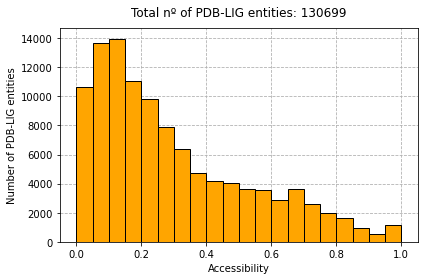

In [37]:
acc_results = results['acc']

plt.hist(acc_results, ec='black', color='orange', bins=[i for i in np.arange(0, 1.001, 0.05)], zorder=2)
plt.grid(linestyle='--')
plt.xlabel("Accessibility")
plt.ylabel("Number of PDB-LIG entities")
plt.title("Total nº of PDB-LIG entities: " + str(len(acc_results)), pad=12)
plt.tight_layout()
plt.savefig("/aloy/home/acomajuncosa/MurD/GitHub/osa-murd/pocketvec/PDB/images/accessibility.png", dpi=300)
plt.show()

In [40]:
results = results.loc[results['acc'] < 0.4].reset_index(drop=True)

In [41]:
results

,PDB,chain,uniprot,INT_LIG,coverage,count,acc,comment
0,10GS,B,P09211,VWW,0.99,0,0.294,all good
1,10GS,A,P09211,VWW,0.99,0,0.295,all good
2,121P,A,P01112,GCP,0.878,0,0.136,all good
3,12AS,B,P00963,AMP,0.985,0,0.130,all good
4,12AS,A,P00963,AMP,0.985,0,0.127,all good
...,...,...,...,...,...,...,...,...
78223,3G3E,C,P14920,G3E,0.98,0,0.133,all good
78224,3G3E,B,P14920,G3E,0.98,0,0.142,all good
78225,3G3E,A,P14920,G3E,0.98,0,0.138,all good
78226,3G49,D,Q6QLL4,NAP,0.877,0,0.078,all good


In [47]:
print("Number of proteins: " + str(len(set(results['uniprot']))))
print("Number of PDB·LIG complexes: " + str(len(results)))
print("Number of unique ligands: " + str(len(set(results['INT_LIG']))))

Number of proteins: 8692
Number of PDB·LIG complexes: 78228
Number of unique ligands: 11770


In [49]:
count_ligands = Counter(results['INT_LIG'])
sorted_ligands = sorted(count_ligands, key=lambda x: count_ligands[x])[::-1]
top = 20
a = np.sum([count_ligands[i] for i in sorted_ligands[:top]])
b = np.sum([count_ligands[i] for i in sorted_ligands])

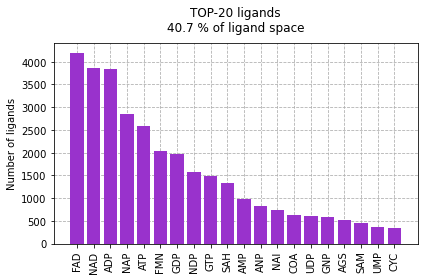

In [50]:
%matplotlib inline
plt.figure(figsize=(6, 4))
plt.grid(linestyle='--', zorder=-2)

for c, i in enumerate(sorted_ligands[:top]):
    
    plt.bar([c], count_ligands[i], color='darkorchid', zorder=2)

plt.xticks([i for i in range(top)], [i for i in sorted_ligands[:top]], rotation=90)
plt.ylabel("Number of ligands")
plt.title("TOP-" + str(top) + " ligands\n" + str(round(a/b*100, 1)) + " % of ligand space", pad=12)
plt.tight_layout()
plt.savefig("/aloy/home/acomajuncosa/MurD/GitHub/osa-murd/pocketvec/PDB/images/top_" + str(top) + "_ligands_bar.png", dpi=300)
plt.show()

mols = [Chem.MolFromInchi(pdbcode_to_inchi[i]) for i in sorted_ligands[:top]]
labs = [i for i in sorted_ligands[:top]]

img=Chem.Draw.MolsToGridImage(mols,molsPerRow=5,subImgSize=(200,200),legends=labs)    
img.save('/aloy/home/acomajuncosa/MurD/GitHub/osa-murd/pocketvec/PDB/images/top_' + str(top) + '_ligands.png')

In [56]:
proteins = Counter(results['uniprot'])
proteins = [proteins[i] for i in proteins]

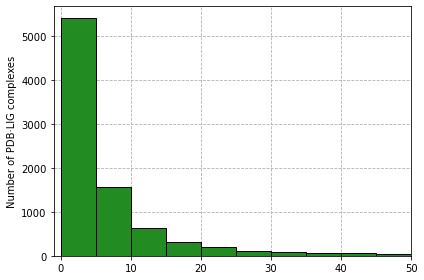

In [83]:
plt.figure(figsize=(6, 4))
plt.grid(linestyle='--', zorder=-2)
plt.hist(proteins, zorder=2, ec='k', bins=[i for i in range(0, max(proteins), 5)], color='forestgreen')
plt.ylabel("Number of PDB·LIG complexes")
plt.xlim([-1, 50])
plt.tight_layout()
plt.show()

In [90]:
random.choice

<bound method Random.choice of <random.Random object at 0x561db511a9e0>>

In [111]:
d = {}
for pdb, chain, uniprot, int_lig, count in zip(results['PDB'], results['chain'], results['uniprot'], results['INT_LIG'], results['count']):
    if uniprot not in d:
        d[uniprot] = []
    d[uniprot].append("_".join([pdb, chain, int_lig, str(count)]))
    
proteins = []
random.seed(42)
for prot in sorted(d):
    proteins.append([prot, ",".join(d[prot]), len(d[prot]), random.sample(sorted(d[prot]), 1)[0]])
    
proteins = pd.DataFrame(proteins, columns=['uniprot', 'structures', 'number of structures', 'reference structure'])
# pickle.dump(proteins, open("/aloy/home/acomajuncosa/MurD/GitHub/alignment/proteins.pkl", "wb"))

In [112]:
proteins

,uniprot,structures,number of structures,reference structure
0,A0A003,"6KV9_A_NAD_0,6KV9_A_UGA_0,6KVC_A_NAD_0,6KVC_A_...",4,6KV9_A_NAD_0
1,A0A010,"5B00_C_GPP_0,5B00_B_GPP_0,5B00_A_GPP_0",3,5B00_A_GPP_0
2,A0A011,"3VK5_B_FPQ_0,3VK5_A_FPQ_0,3VKA_A_FPQ_0,3VKB_B_...",9,3VKB_B_FPS_0
3,A0A022MQ12,"6SJ2_B_3HA_0,6SJ2_A_3HA_0,6SJ3_B_3HB_0,6SJ3_A_...",6,6SJ2_B_3HA_0
4,A0A022MRT4,"6SIW_B_AMP_0,6SIW_A_AMP_0,6SIX_B_ANP_0,6SIX_A_...",14,6SIX_B_ANP_0
...,...,...,...,...
8687,X5EJW5,"6XJI_D_AGS_0,6XJI_C_AGS_0",2,6XJI_C_AGS_0
8688,X5I2D7,"5H04_A_NAI_0,5WTZ_A_NAD_0,5WU0_A_NAI_0",3,5WTZ_A_NAD_0
8689,X5IYZ1,"6J38_B_FAD_0,6J38_A_FAD_0,6J39_B_FAD_0,6J39_A_...",6,6J39_A_FAD_0
8690,X5MEI1,"7MPO_H_A3P_0,7MPO_B_A3P_0,7MPO_G_A3P_0,7MPO_C_...",15,7MPP_K_5GP_1


In [109]:
proteins['structures'].tolist()[0]

'6KV9_A_NAD_0,6KV9_A_UGA_0,6KVC_A_NAD_0,6KVC_A_UPG_0'

In [129]:
uniprot = 'A0A003'
structures = '6KV9_A_NAD_0,6KV9_A_UGA_0,6KVC_A_NAD_0,6KVC_A_UPG_0'.split(",")
ref_structure = "6KV9_A_NAD_0"
ref_structure = "_".join(ref_structure.split("_")[:-1])

In [130]:
path = os.path.join("/aloy/home/acomajuncosa/MurD/GitHub/structures")


mtx_path = os.path.join("/aloy/home/acomajuncosa/MurD/GitHub/alignment/MSA/mtx", uniprot)
outpath = os.path.join('/aloy/home/acomajuncosa/MurD/GitHub/alignment/pockets', uniprot)
vis_path = os.path.join("/aloy/home/acomajuncosa/MurD/GitHub/alignment/MSA/visualization", uniprot)
path_to_aligned_sts = os.path.join("/aloy/home/acomajuncosa/MurD/GitHub/alignment/MSA/aligned_structures/", uniprot)
path_to_reports = os.path.join("/aloy/home/acomajuncosa/MurD/GitHub/alignment/MSA/reports/", uniprot)

if os.path.exists(mtx_path) is False: os.makedirs(mtx_path)
if os.path.exists(outpath) is False: os.makedirs(outpath)
if os.path.exists(vis_path) is False: os.makedirs(vis_path)
if os.path.exists(path_to_aligned_sts) is False: os.makedirs(path_to_aligned_sts)
if os.path.exists(path_to_reports) is False: os.makedirs(path_to_reports)

In [131]:
################################
#---The real script starts here
################################


# Extract the data (st, lig, ctr)
for structure in structures:
    
    pdb = structure.split("_")[0]
    chain = structure.split("_")[1]
    ligand = structure.split("_")[2]
    count = structure.split("_")[3]


    label = "_".join([pdb, chain, ligand])
    
    
    st = label + "/" + label + ".pdb"
    lig = label + "/" + ligand + "_" + count + ".pdb"
    ctr = label + "/" + ligand + "_" + count + "_centroid.pdb"

    tar = tarfile.open(os.path.join(path, pdb[1:3], label + ".tar.gz"), "r")
    tar.extract(st, path=os.path.join(outpath))
    tar.extract(lig, path=os.path.join(outpath))
    tar.extract(ctr, path=os.path.join(outpath))
    tar.close()
    
# Select one st as reference (st2)
shutil.copyfile(os.path.join(outpath, ref_structure, ref_structure + ".pdb"), os.path.join(vis_path, "cluster_REFERENCE.pdb"))

'/aloy/home/acomajuncosa/MurD/GitHub/alignment/MSA/visualization/A0A003/cluster_REFERENCE.pdb'

In [132]:
# Some functions

# Read trans/rot matrix for alignment (TM-align)
def read_mtx(file):
    f = open(file, "r").readlines()[2:5]
    f = np.array([i.split()[1:] for i in f], dtype='float32')
    t = np.array(f[:,0])
    u = np.array([f[0][1:], f[1][1:], f[2][1:]])
    return t, u

# Get 3D points from ligand centroid
def get_3d_points(file):
    point = PDBParser().get_structure("point", file)[0]
    return [at.get_coord() for at in point.get_atoms()][0]

# Get line to merge pdbs
def get_line_point(file):
    f = open(file, "r").readlines()
    return f[0]

In [137]:
command

'/aloy/home/acomajuncosa/programs/TM_align/TMalign /aloy/home/acomajuncosa/MurD/GitHub/alignment/pockets/A0A003/A0A003/6KV9_A_NAD.pdb /aloy/home/acomajuncosa/MurD/GitHub/alignment/pockets/A0A003/A0A003/6KV9_A_NAD.pdb -m /aloy/home/acomajuncosa/MurD/GitHub/alignment/MSA/mtx/A0A003/6KV9_A_NAD_6KV9_A_NAD.txt'

In [158]:
# Structural superposition against ref (st2)
for structure in structures:
    
    pdb = structure.split("_")[0]
    chain = structure.split("_")[1]
    ligand = structure.split("_")[2]
    count = structure.split("_")[3]
    
    st1 = "_".join(structure.split("_")[:-1])
    count = structure.split("_")[-1]
    
    # Superpose using TM-align
    command = '/aloy/home/acomajuncosa/programs/TM_align/TMalign ' + os.path.join(outpath, st1, st1 + '.pdb') + ' ' + os.path.join(outpath, ref_structure, ref_structure + '.pdb') + ' -m ' + os.path.join(mtx_path, ref_structure + "_" + st1 + ".txt")
    os.system(command)
    

    t, u = read_mtx(os.path.join(mtx_path, ref_structure + "_" + st1 + ".txt"))


    # Protein
    structure = PDBParser().get_structure("st", os.path.join(outpath, st1, st1 + ".pdb"))[0]
    for atom in structure.get_atoms():
        #atom.transform(rotation_matrix, translation_matrix)
        x0, y0, z0 = atom.get_coord()[0], atom.get_coord()[1], atom.get_coord()[2]
        x = t[0] + u[0][0]*x0 + u[0][1]*y0 + u[0][2]*z0
        y = t[1] + u[1][0]*x0 + u[1][1]*y0 + u[1][2]*z0
        z = t[2] + u[2][0]*x0 + u[2][1]*y0 + u[2][2]*z0
        atom.coord = np.array([x, y, z])
    io = PDBIO()
    io.set_structure(structure)
    io.save(os.path.join(outpath, st1, st1 + '_aligned.pdb'))

    label = "_".join([pdb, chain, ligand])
    lig = ligand + "_" + count
    ctr = ligand + "_" + count + "_centroid"

    shutil.copyfile(os.path.join(outpath, st1, st1 + '_aligned.pdb'), os.path.join(path_to_aligned_sts, st1 + '_aligned.pdb'))
    
    
    # Centroid
    structure = PDBParser().get_structure("st", os.path.join(outpath, st1, ctr + ".pdb"))[0]
    for atom in structure.get_atoms():
        # atom.transform(rotation_matrix, translation_matrix)
        x0, y0, z0 = atom.get_coord()[0], atom.get_coord()[1], atom.get_coord()[2]
        x = t[0] + u[0][0]*x0 + u[0][1]*y0 + u[0][2]*z0
        y = t[1] + u[1][0]*x0 + u[1][1]*y0 + u[1][2]*z0
        z = t[2] + u[2][0]*x0 + u[2][1]*y0 + u[2][2]*z0
        atom.coord = np.array([x, y, z])
    io = PDBIO()
    io.set_structure(structure)
    io.save(os.path.join(outpath, st1, ctr + '_aligned.pdb'))
    
    # Ligand
    structure = PDBParser().get_structure("st", os.path.join(outpath, st1, lig + ".pdb"))[0]
    for atom in structure.get_atoms():
        # atom.transform(rotation_matrix, translation_matrix)
        x0, y0, z0 = atom.get_coord()[0], atom.get_coord()[1], atom.get_coord()[2]
        x = t[0] + u[0][0]*x0 + u[0][1]*y0 + u[0][2]*z0
        y = t[1] + u[1][0]*x0 + u[1][1]*y0 + u[1][2]*z0
        z = t[2] + u[2][0]*x0 + u[2][1]*y0 + u[2][2]*z0
        atom.coord = np.array([x, y, z])
    io = PDBIO()
    io.set_structure(structure)
    io.save(os.path.join(outpath, st1, lig + '_aligned.pdb'))

    shutil.copyfile(os.path.join(outpath, st1, ctr + '_aligned.pdb'), os.path.join(vis_path, st1 + "_" + "_".join(ctr.split("_")[1:]) + ".pdb"))
    shutil.copyfile(os.path.join(outpath, st1, lig + '_aligned.pdb'), os.path.join(vis_path, st1 + "_" + "_".join(lig.split("_")[1:]) + ".pdb"))

In [165]:
# Read the coordinates from all centroids
labs, coords = [], []

for file in sorted(os.listdir(vis_path)):
    if "centroid" in file and "REFERENCE" not in file:
        labs.append(file)
        coord = get_3d_points(os.path.join(vis_path, file))
        coords.append([coord[0], coord[1], coord[2]])

coords = np.array(coords)

In [194]:
import pymesh

In [196]:
pymesh.load_pymesh?

Object `pymesh.load_pymesh` not found.


In [ ]:












if len(d) > 1:

	# Clustering
	clustering = DBSCAN(eps=10, min_samples=2, metric='euclidean').fit(coords)

	# Pretty print
	for cluster in sorted(set(clustering.labels_)):
		with open(os.path.join(vis_path, "cluster_" + str(cluster) + ".pdb"), "w") as f:
			f.write("HEADER\n")
			for lab, numb in zip(labs, clustering.labels_):
				if numb == cluster:
					l = get_line_point(os.path.join(vis_path, lab))
					f.write(l)
			f.write("END")

	# Print report(s)
	with open(os.path.join(path_to_reports, domain + ".tsv"), "w") as f:
		f.write("\n".join(["\t".join([i,str(j)]) for i,j in zip(labs, clustering.labels_)]))

	report = {i:j for i,j in zip(labs, clustering.labels_)}
	pickle.dump(report, open(os.path.join(path_to_reports, domain + ".pkl"), "wb"))


else:  # In case only one st in this domain

	# Pretty print
	with open(os.path.join(vis_path, "cluster_" + str(0) + ".pdb"), "w") as f:
		f.write("HEADER\n")
		for lab, numb in zip(labs, [0]):
			l = get_line_point(os.path.join(vis_path, lab))
			f.write(l)
		f.write("END")

	# Print report(s)
	with open(os.path.join(path_to_reports, domain + ".tsv"), "w") as f:
		f.write("\n".join(["\t".join([i,str(j)]) for i,j in zip(labs, [0])]))

	report = {i:j for i,j in zip(labs,[0])}
	pickle.dump(report, open(os.path.join(path_to_reports, domain + ".pkl"), "wb"))

In [9]:
def get_centroid(infile, outfile):
    
    parser = PDBParser()
    structure = parser.get_structure("lig", infile)

    res = [i for i in structure.get_residues()][0]
    ligatoms = [at.coord for at in res.get_atoms()]
    x = np.mean(np.array(ligatoms)[:,0])
    y = np.mean(np.array(ligatoms)[:,1])
    z = np.mean(np.array(ligatoms)[:,2])
    center = np.array([x, y, z], dtype=np.float32)

    x, y, z = str(round(x, 3)), str(round(y, 3)), str(round(z, 3))
    ctr = " "*(8-len(x)) + x + " "*(8-len(y)) + y + " "*(8-len(z)) + z
    text = """HEADER\nHETATM    1   C  CTR A   1    """ + ctr + """  1.00  1.00           C\nEND"""

    with open(outfile, "w") as f:
        f.write(text)


def SASA(prot, lig): 

    # Protonation gives too many issues. Avoid it
    
    #compute ligand SASA
    #lig_h = Chem.rdmolops.AddHs(lig, addCoords=True, explicitOnly=True)
    lig_h = lig
    # Get Van der Waals radii (angstrom)
    ptable = Chem.GetPeriodicTable()
    radii = [ptable.GetRvdw(atom.GetAtomicNum()) for atom in lig_h.GetAtoms()]
    # Compute solvent accessible surface area
    lig_sasa = rdFreeSASA.CalcSASA(lig_h, radii)

    # Join protein & ligand
    comp = Chem.CombineMols(prot, lig)
    comp_h = comp
    #comp_h = Chem.AddHs(comp, addCoords=True)
    # Get Van der Waals radii (angstrom)
    ptable = Chem.GetPeriodicTable()
    radii = [ptable.GetRvdw(atom.GetAtomicNum()) for atom in comp_h.GetAtoms()]
    # Compute solvent accessible surface area
    comp_sasa = rdFreeSASA.CalcSASA(comp_h, radii)
    comp_lig = Chem.GetMolFrags(comp_h, asMols=True,  sanitizeFrags=True)
    comp_lig = [i for i in comp_lig if lig_h.GetNumHeavyAtoms() == i.GetNumHeavyAtoms()][0]
    
    lig_sasa_free = 0
    for a in lig_h.GetAtoms():
        lig_sasa_free += float(a.GetProp("SASA"))

    lig_sasa_bound = 0
    for a in comp_lig.GetAtoms():
        lig_sasa_bound += float(a.GetProp("SASA"))
        
    return round(lig_sasa_free, 3), round(lig_sasa_bound, 3)


pdbcode_to_inchi = pd.read_csv("/aloy/home/acomajuncosa/MurD/GitHub/osa-murd/data/PDB/mapping/Components-inchi.ich.txt", sep="\t", header=None, names=['inchi', 'PDB', 'name'], usecols=[0,1])  
# From df to dict's  // PDB-LIGs
d = {}
for i,j in zip(pdbcode_to_inchi['inchi'], pdbcode_to_inchi['PDB']):
    if str(j) == 'nan': j = "NA"
    d[str(j)] = i
pdbcode_to_inchi = d; del d


def get_xml(pdb_id, path_to_xml='.', force_rerun=False):

	"""
	Inspired in ssbio, def download_sifts_xml

	"""
	
	filename = '{}.xml.gz'.format(pdb_id.lower())
	url = os.path.join('http://ftp.ebi.ac.uk/pub/databases/msd/sifts/xml/', filename)
	outfile = os.path.join(path_to_xml, pdb_id.lower() + '.xml.gz')
	out_xml = os.path.join(path_to_xml, pdb_id.lower() + '_' + str(task_id) + '.xml')
	
	# Download xml.gz
	if force_rerun is True or pdb_id.lower() + '.xml.gz' not in set(os.listdir(path_to_xml)):
		urllib.request.urlretrieve(url, outfile)
		
	# Uncompress
	with gzip.open(outfile, 'rb') as f:
		with open(out_xml, "wb") as out:
			file_content = f.read()
			out.write(file_content)
			
	return out_xml

In [ ]:
# task_id = 0 

# path_to_summary = os.path.join("/aloy/home/acomajuncosa/MurD/GitHub/osa-murd/pocketvec/PDB/summary", "summary_" + str(task_id) + ".tsv")

In [ ]:
1A0H	E	P00735	0G6	0.0	--	--	coverage < 0.8

In [224]:
data.loc[data['PDB'] == "1A0Q"]

,PDB,INT_LIG,LIG,HET,type,chain,uniprot
50,1A0Q,HEP,ZN,NaN,prot,H,P01869
51,1A0Q,HEP,ZN,NaN,prot,L,P01837


In [225]:
pdb = "1A0Q"
int_lig = 'HEP'
lig = ['ZN']
het = np.nan
chain_id = "H"
uniprot = "P01869"

path = os.path.join("/aloy/home/acomajuncosa/MurD/GitHub/structures", pdb[1:3], pdb + "_" + chain_id + "_" + int_lig)
if os.path.exists(path) is False: os.makedirs(path)
os.chdir(os.path.join(path))

In [226]:
### 1. Create directory & download pdb structure
with gzip.open('/aloy/home/acomajuncosa/programs/localpdb/mirror/pdb/' + pdb[1:3].lower() + '/pdb' + pdb.lower() + '.ent.gz', 'rb') as f_in:
    with open(os.path.join(path, pdb + ".pdb"), 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
        
ligands_to_remove = ['W']
ligands_to_remove.append("H_" + " "*(3-len(int_lig)) + int_lig)
ligands_to_remove.append("H_" + int_lig + " "*(3-len(int_lig)))

if type(lig) == list:
    for l in lig:
        ligands_to_remove.append("H_" + " "*(3-len(l)) + l)
        ligands_to_remove.append("H_" + l + " "*(3-len(l)))
    ligands_to_remove = set(ligands_to_remove)

In [227]:
### 2. Take only the first model
parser = PDBParser()
path_in = os.path.join(path, pdb + ".pdb")
path_out = path
structure = parser.get_structure("st", path_in) # Take only the first model. Trivial for X-ray, only 1st for NMR

if len(structure) > 1:
    structure = structure[0]

io = PDBIO()
io.set_structure(structure)
io.save(os.path.join(path_out, pdb + "_model.pdb"))

/home/acomajuncosa/programs/anaconda3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 3747.
  PDBConstructionWarning,
/home/acomajuncosa/programs/anaconda3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 3748.
  PDBConstructionWarning,
/home/acomajuncosa/programs/anaconda3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 3773.
  PDBConstructionWarning,
/home/acomajuncosa/programs/anaconda3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 3818.
  PDBConstructionWarning,


In [228]:
len(structure)

1

In [229]:
### 3. Remove water molecules and ligands, but not nonstd residues, and select the studied chain
parser = PDBParser()
path_in = os.path.join(path, pdb + "_model.pdb")
path_out = path
structure = parser.get_structure("st", path_in)

class remove_ligs(Select):
    def accept_residue(self, residue):
        if residue.get_id()[0] not in ligands_to_remove and residue.get_parent().id == chain_id:
            return 1
        else:
            return 0

io = PDBIO()
io.set_structure(structure)
io.save(os.path.join(path, pdb + "_" + chain_id + "_st.pdb"), remove_ligs())

In [230]:
### 4. Get the number of interesting ligands in the chain. If none, do not continue
interesting_ligands = [i for i in structure.get_residues() if i.get_resname() == int_lig and i.get_parent().id == chain]

In [231]:
### 5. Remove hydrogens
command = 'python /aloy/home/acomajuncosa/programs/structureChecking/bin/check_structure -i ' + os.path.join(path_out , pdb + "_" + chain_id + '_st.pdb') + ' -o ' + os.path.join(path_out , pdb + "_" + chain_id + '_hydrogens.pdb') + ' --force_save --non_interactive rem_hydrogen --remove Yes'
o = os.popen(command).read()
sys.stderr.write(o + "\n\n")
sys.stderr.flush()

### 6. Select occupancies
command = 'python /aloy/home/acomajuncosa/programs/structureChecking/bin/check_structure -i ' + os.path.join(path_out , pdb + "_" + chain_id + '_hydrogens.pdb') + ' -o ' + os.path.join(path_out , pdb + "_" + chain_id + '_altloc.pdb') + ' --force_save --non_interactive altloc --select occupancy'
o = os.popen(command).read()
sys.stderr.write(o + "\n\n")
sys.stderr.flush()

shutil.copyfile(os.path.join(path_out , pdb + "_" + chain_id + '_altloc.pdb'), os.path.join(path_out , pdb + "_" + chain_id + '_' + int_lig + '.pdb'))

=                   BioBB structure checking utility v3.0.3                   =
=                 A. Hospital, P. Andrio, J.L. Gelpi 2018-20                  =

Structure /aloy/home/acomajuncosa/MurD/GitHub/structures/A0/1A0Q_H_HEP/1A0Q_H_st.pdb loaded
 Title: 
 Experimental method: unknown
 Resolution: 0.0 A

 Num. models: 1
 Num. chains: 1 (H: Protein)
 Num. residues:  205
 Num. residues with ins. codes:  5
 Num. HETATM residues:  0
 Num. ligands or modified residues:  0
 Num. water mol.:  0
 Num. atoms:  1540

Running rem_hydrogen. Options: --remove Yes
No residues with Hydrogen atoms found
Structure not modified, saving due to --force_save option
Final Num. models: 1
Final Num. chains: 1 (H: Protein)
Final Num. residues:  205
Final Num. residues with ins. codes:  5
Final Num. HETATM residues:  0
Final Num. ligands or modified residues:  0
Final Num. water mol.:  0
Final Num. atoms:  1540
Structure saved on /aloy/home/acomajuncosa/MurD/GitHub/structures/A0/1A0Q_H_HEP/1A0Q_H_hydrogen

'/aloy/home/acomajuncosa/MurD/GitHub/structures/A0/1A0Q_H_HEP/1A0Q_H_HEP.pdb'

In [192]:
if len(interesting_ligands) == 0:
    pass
else:
    print('yay')

In [232]:
### 5. Check coverage

### 5.1. Get xml
path_to_xml = "/aloy/home/acomajuncosa/PocketVec_v2/HT/data/PDB/coverage/xml"
task_id = 0
path_to_sifts = get_xml(pdb, path_to_xml, force_rerun=False)

In [254]:
def map_pdbres_to_uniprot(pdb_res, chain_id, sifts_file):
    
    """
    Given a pdb residue, a chain id and a sifts_file, map it with the corresponding
    uniprot residue   
    
    """

    parser = etree.XMLParser(ns_clean=True)
    tree = etree.parse(sifts_file, parser)
    root = tree.getroot()

    my_pdb_resnum = None

    # TODO: "Engineered_Mutation is also a possible annotation, need to figure out what to do with that
    my_pdb_annotation = False

    # Find the right chain (entities in the xml doc)
    ent = './/{http://www.ebi.ac.uk/pdbe/docs/sifts/eFamily.xsd}entity'


    for chain in root.findall(ent):
        if True: #chain.attrib['entityId'] == chain_id: # this is not right (e.g. 1a0h, chain E in pdb is chain D in uniprot! check xml)
            # Find the "crossRefDb" tag that has the attributes dbSource="PDB" and  dbResNum="pdb_res"
            # Then match it to the crossRefDb dbResNum that has the attribute dbSource="PDBresnum"
            # Check if uniprot + resnum even exists in the sifts file (it won't if the pdb doesn't contain the residue)
            ures = './/{http://www.ebi.ac.uk/pdbe/docs/sifts/eFamily.xsd}crossRefDb[@dbSource="PDB"][@dbResNum="%s"][@dbChainId="%s"]' % (pdb_res, chain_id)
            my_pdb_residue = chain.findall(ures)
            
            if len(my_pdb_residue) == 1:
                # Get crossRefDb dbSource="PDB"
                parent = my_pdb_residue[0].getparent()
                pres = './/{http://www.ebi.ac.uk/pdbe/docs/sifts/eFamily.xsd}crossRefDb[@dbSource="UniProt"]'
                my_pdb_residue = parent.findall(pres)
                if len(my_pdb_residue) == 0 or my_pdb_residue[0].attrib['dbResNum'] == 'null':
                    pass
                else:
                    my_pdb_resnum = int(my_pdb_residue[0].attrib['dbResNum'])


                    # Get <residueDetail dbSource="PDBe" property="Annotation">
                    # Will be Not_Observed if it is not seen in the PDB
                    anno = './/{http://www.ebi.ac.uk/pdbe/docs/sifts/eFamily.xsd}residueDetail[@dbSource="PDBe"][@property="Annotation"]'
                    my_pdb_annotation = parent.findall(anno)
                    if len(my_pdb_annotation) == 1:
                        my_pdb_annotation = my_pdb_annotation[0].text
                        if my_pdb_annotation == 'Not_Observed':
                            my_pdb_annotation = False
                    else:
                        my_pdb_annotation = True

                    return pdb_res, my_pdb_resnum, my_pdb_annotation
            else:
                pass

    return pdb_res, my_pdb_resnum, my_pdb_annotation

In [262]:
parser = PDBParser()
structure = parser.get_structure("st", os.path.join(path_out , pdb + '_' + chain_id + "_" + int_lig + '.pdb'))

In [263]:
# 5.2 Get uniprot sequence

baseUrl = "http://www.uniprot.org/uniprot/"
currentUrl = baseUrl + uniprot + ".fasta"
response = r.post(currentUrl)
cData = ''.join(response.text)

Seq=StringIO(cData)
pSeq=list(SeqIO.parse(Seq,'fasta'))
prot_sequence = str(pSeq[0].seq)

In [265]:
# 5.3 Get coverage residue by residue
cov = {}
for i in structure.get_residues():
    numb = str(i.get_id()[1])
    a, b, c = map_pdbres_to_uniprot(numb, chain_id, path_to_sifts)
    cov[a] = [b, c]
cov

{'2': [None, False],
 '3': [None, False],
 '4': [None, False],
 '5': [None, False],
 '6': [None, False],
 '7': [None, False],
 '8': [None, False],
 '9': [None, False],
 '10': [None, False],
 '11': [None, False],
 '12': [None, False],
 '13': [None, False],
 '14': [None, False],
 '15': [None, False],
 '16': [None, False],
 '17': [None, False],
 '18': [None, False],
 '19': [None, False],
 '20': [None, False],
 '21': [None, False],
 '22': [None, False],
 '23': [None, False],
 '24': [None, False],
 '25': [None, False],
 '26': [None, False],
 '27': [None, False],
 '28': [None, False],
 '29': [None, False],
 '30': [None, False],
 '31': [None, False],
 '32': [None, False],
 '33': [None, False],
 '34': [None, False],
 '35': [None, False],
 '36': [None, False],
 '37': [None, False],
 '38': [None, False],
 '39': [None, False],
 '40': [None, False],
 '41': [None, False],
 '42': [None, False],
 '43': [None, False],
 '44': [None, False],
 '45': [None, False],
 '46': [None, False],
 '47': [None, Fals

In [266]:
numb_covered = Counter([cov[i][1] for i in cov])[True]
total_seq = len(prot_sequence)
coverage = round(numb_covered/total_seq, 3)

In [ ]:
if coverage < 0.8:
    pass
else:
    pass

In [147]:
### 6. Save ligand independently and calculate SASA (free/bound)

parser = PDBParser()
structure = parser.get_structure("st", os.path.join(path, pdb + "_model.pdb"))

for c, interesting_ligand in enumerate(interesting_ligands):
    
    # 5. Select ligand and save it separately
    class LigSelect(Select):
        def accept_residue(self, residue):
            if residue == interesting_ligand:
                return 1
            else:
                return 0

    io = PDBIO()
    io.set_structure(structure)
    io.save(os.path.join(path, int_lig + "_" + str(c) + ".pdb"), LigSelect())
    
    # Get centroid
    get_centroid(os.path.join(path, int_lig + "_" + str(c) + ".pdb"), os.path.join(path, int_lig + "_" + str(c) + "_centroid.pdb"))
    command = 'obabel ' + os.path.join(path, int_lig + "_" + str(c) + "_centroid.pdb") + " -O " + os.path.join(path, int_lig + "_" + str(c) + "_centroid.sd")
    os.system(command)
    
    # Get SASA
    prot = Chem.MolFromPDBFile(os.path.join(path, pdb + "_" + chain_id + "_" + int_lig + ".pdb"))
    lig = Chem.MolFromPDBFile(os.path.join(path, int_lig + "_" + str(c) + ".pdb"))
    if lig.GetNumHeavyAtoms() == Chem.MolFromInchi(pdbcode_to_inchi[int_lig]).GetNumHeavyAtoms():
        lig_sasa_free, lig_sasa_bound = SASA(prot, lig)
    else:
        lig_sasa_free, lig_sasa_bound = np.nan, np.nan
    acc = round(lig_sasa_bound / lig_sasa_free, 3)

In [149]:
path = os.path.join("/aloy/home/acomajuncosa/MurD/GitHub/structures", pdb[1:3])
os.chdir(path)   
tar = tarfile.open(pdb + "_" + chain_id + "_" + int_lig + ".tar.gz", "w:gz")
tar.add(pdb + "_" + chain_id + "_" + int_lig)
shutil.rmtree(pdb + "_" + chain_id + "_" + int_lig)
tar.close()